In [1]:
%load_ext autoreload
%autoreload 1
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm import tqdm as tqdm

In [2]:
# Own modules
from TorchMalaria import *
from Discriminative import *
from Generative import *
from CONSTANTS import *
%aimport TorchMalaria, Discriminative, Generative, CONSTANTS

In [3]:
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

dataset = DataMalaria("ImageList.csv", transform=torchvision.transforms.ToTensor(), TTS = True)
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

Random Seed:  999


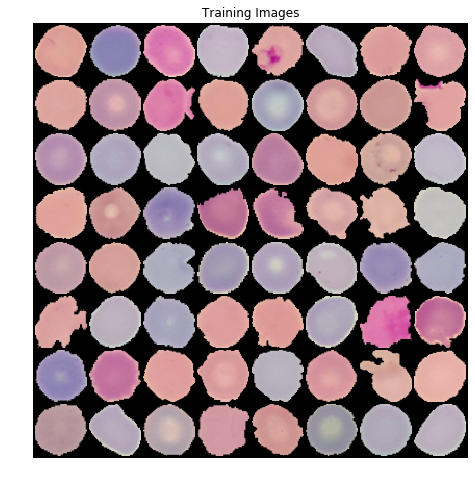

In [4]:
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [5]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [6]:
# Create the generator
netG = GenerativeNetwork(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)
netG.double()
# Print the model
print(netG)

# Create the Discriminator
netD = DiscriminativeNetwork(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)
netD.double()
# Print the model
print(netD)

GenerativeNetwork(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
    (14): MaxPool2

In [8]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
fixed_noise = fixed_noise.double()
 
# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [9]:
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0


# For each epoch
pbar = tqdm(total=num_epochs*len(dataloader))
pbar.write("Starting Training Loop...")
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        
        # Format batch
        real_cpu = data.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        label = label.double()
        
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        noise = noise.double()
        # Generate fake image batch with G
        fake = netG(noise)
        
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 10 == 0:
            pbar.write('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 30 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
        
        if iters % 300 == 0:
            torch.save(netD.state_dict(), "netD.pt")
            torch.save(netG.state_dict(), "netG.pt")
        
        iters += 1
        pbar.update()
        
for i in range(10):
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
    img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

torch.save(netD.state_dict(), "netD.pt")
torch.save(netG.state_dict(), "netG.pt")

pbar.close()


  0%|          | 0/3550 [00:00<?, ?it/s]

Starting Training Loop...


  0%|          | 0/3550 [00:14<?, ?it/s]

[0/50][0/71]	Loss_D: 1.9465	Loss_G: 11.6539	D(x): 0.4033	D(G(z)): 0.5923 / 0.0000


  0%|          | 11/3550 [02:03<11:28:56, 11.68s/it]

[0/50][10/71]	Loss_D: 0.0273	Loss_G: 9.8450	D(x): 0.9975	D(G(z)): 0.0242 / 0.0001


  1%|          | 21/3550 [04:17<12:30:55, 12.77s/it]

[0/50][20/71]	Loss_D: 0.2537	Loss_G: 19.1891	D(x): 0.9962	D(G(z)): 0.1780 / 0.0000


  1%|          | 30/3550 [06:02<10:28:11, 10.71s/it]

[0/50][30/71]	Loss_D: 0.1471	Loss_G: 9.4423	D(x): 0.9801	D(G(z)): 0.0804 / 0.0004


  1%|          | 41/3550 [07:39<8:59:53,  9.23s/it]

[0/50][40/71]	Loss_D: 0.1330	Loss_G: 7.8733	D(x): 0.9832	D(G(z)): 0.0239 / 0.0023


  1%|▏         | 51/3550 [09:11<8:58:16,  9.23s/it]

[0/50][50/71]	Loss_D: 0.0308	Loss_G: 5.4749	D(x): 0.9842	D(G(z)): 0.0101 / 0.0099


  2%|▏         | 60/3550 [10:44<9:09:39,  9.45s/it]

[0/50][60/71]	Loss_D: 0.0533	Loss_G: 5.4999	D(x): 0.9730	D(G(z)): 0.0035 / 0.0058


  2%|▏         | 61/3550 [10:45<9:22:09,  9.67s/it]Traceback (most recent call last):
  File "/home/simcha/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/simcha/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/simcha/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/simcha/anaconda3/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: 

In [1]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

NameError: name 'plt' is not defined

In [10]:
loadGAN = GenerativeNetwork(ngpu)
loadGAN.double()
loadGAN.load_state_dict(torch.load("netG.pt"))

RuntimeError: Error(s) in loading state_dict for GenerativeNetwork:
	size mismatch for main.0.weight: copying a param with shape torch.Size([100, 96, 4, 4]) from checkpoint, the shape in current model is torch.Size([100, 512, 4, 4]).
	size mismatch for main.1.weight: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for main.1.bias: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for main.1.running_mean: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for main.1.running_var: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for main.3.weight: copying a param with shape torch.Size([96, 48, 4, 4]) from checkpoint, the shape in current model is torch.Size([512, 256, 4, 4]).
	size mismatch for main.4.weight: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for main.4.bias: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for main.4.running_mean: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for main.4.running_var: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for main.6.weight: copying a param with shape torch.Size([48, 24, 4, 4]) from checkpoint, the shape in current model is torch.Size([256, 128, 4, 4]).
	size mismatch for main.7.weight: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for main.7.bias: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for main.7.running_mean: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for main.7.running_var: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for main.9.weight: copying a param with shape torch.Size([24, 12, 4, 4]) from checkpoint, the shape in current model is torch.Size([128, 64, 4, 4]).
	size mismatch for main.10.weight: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for main.10.bias: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for main.10.running_mean: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for main.10.running_var: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for main.12.weight: copying a param with shape torch.Size([12, 3, 4, 4]) from checkpoint, the shape in current model is torch.Size([64, 3, 4, 4]).

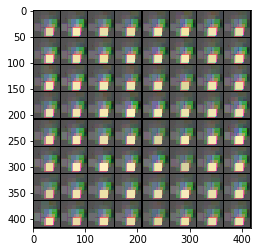

In [60]:


a = np.transpose(vutils.make_grid(fake, padding=2, normalize=True),(1,2,0))
plt.imshow(a)

dictNoise = {"z": fixed_noise[0].detach().numpy(), "o": fixed_noise[1].detach().numpy()}

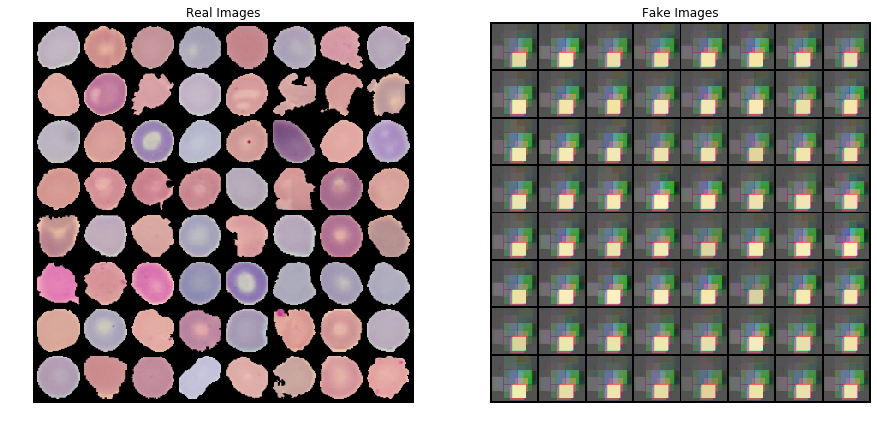

In [62]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch.to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()